In [1]:
RKP = "DL031"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set_theme(style="darkgrid")

In [2]:
# Load datasets and rename columns, load all aqi data but specify metro data name
def loadcsv(city="./data/rkpuram.csv"):
    met = pd.read_csv(city,delimiter=';',skiprows=24)
    aqi = pd.read_csv('./data/station_hour.csv')
    print(aqi.columns)
    met.rename(columns={'# Date': 'Date',}, inplace=True)
    met.rename(columns={'UT time': 'Time',}, inplace=True)
    aqi['Time'] = aqi['Datetime'].str[-8:-3]
    aqi['Date'] = aqi['Datetime'].str[0:10]
    stations = ["DL"+str(x).zfill(3) for x in range(1,39)]
    split_aqi = {}
    for i in range(len(stations)):
        split_aqi[stations[i]] = (aqi[aqi['StationId'] == stations[i]])
    return met,aqi,split_aqi
met,aqi,split_aqi = loadcsv()

C:\Users\confusement\miniconda3\envs\mlc\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Index(['StationId', 'Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3',
       'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket'],
      dtype='object')


In [32]:
# Pre - processing and loading data
class dataset:
    def __init__(self,met,aqi,split_aqi):
            self.metro_data = met
            self.aqi_data = aqi
            self.split_aqi = split_aqi
    def mergedData(self,station,rlist=['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3'],roll=48,shift=48):
        df_aqi = self.getdf(station)
        df = pd.merge(df_aqi, self.metro_data, how='inner', on=['Date', 'Time'])
        print("Merged Dataset Size",len(df))
        
        #Pre Processing merged Data
        df['Year'] = df['Date'].str[0:4]
        df['Month'] = df['Date'].str[5:7].astype(np.float64)
        df['Day'] = df['Date'].str[8:10].astype(np.float64)
        df['Hour'] = df['Time'].str[0:2]
        
        # TRIG TRANSFORMATIONS
        df['windX'] = np.cos(np.deg2rad(df['Wind direction'])) * df['Wind speed']
        df['windY'] = np.sin(np.deg2rad(df['Wind direction'])) * df['Wind speed']
        df['hourX'] = np.cos((df['Hour'].astype(np.float64)-1)*np.pi/24)
        df['hourY'] = np.sin((df['Hour'].astype(np.float64)-1)*np.pi/24)
        df['MonthX'] = np.cos((df['Month'].astype(np.float64)-1)*np.pi/12)
        df['MonthY'] = np.sin((df['Month'].astype(np.float64)-1)*np.pi/12)
        
        import datetime
        df['Date'] = pd.to_datetime(df['Date'])
        df['isWeekend'] =  (df['Date'].dt.dayofweek>=5).astype(int)
        
        df.interpolate(method='linear', limit=5,inplace=True)
        
        # Drop Additional columns
        df.drop('Benzene', axis=1, inplace=True)
        df.drop('Toluene',axis=1, inplace=True)
        df.drop('Xylene', axis=1,inplace=True)
        df.drop('AQI_Bucket',axis=1,inplace=True)
        df.drop('Datetime',axis=1,inplace=True)
        df.drop('StationId',axis=1,inplace=True)
        df.drop('Short-wave irradiation',axis=1,inplace=True)
        df.drop('Date',axis=1,inplace=True)
        df.drop('Time',axis=1,inplace=True)
        
        # Rolling and shifting 
        print("Size before roll",len(df))
        for i in rlist:
            df[i+'_lag1'] = df[i].shift(24)
            df[i+'_lag2'] = df[i].shift(48)
        for i in rlist:
            df[i+"_pred1"] = df[i].shift(-24)
            df[i+"_pred2"] = df[i].shift(-48)
        for i in rlist:
            for j in range(24):
                df[i+"_t-"+str(j)] = df[i].shift(j)
                df[i+"_t+"+str(j)] = df[i].shift(-j-shift)
        df.dropna(inplace=True)
        print("Size after roll",len(df))
        
        return df.copy()
    def getdf(self,station):
        return self.split_aqi[station]
    def plot(self,station):
        df = self.getdf(station)
    def stats(self):
        pass
dat = dataset(met,aqi,split_aqi)
df = dat.mergedData('DL031')
df

Merged Dataset Size 44035
Size before roll 44035
Size after roll 14861


,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,AQI,...,O3_t-19,O3_t+19,O3_t-20,O3_t+20,O3_t-21,O3_t+21,O3_t-22,O3_t+22,O3_t-23,O3_t+23
165,33.00,102.17,6.33,14.45,22.22,23.65,0.17,10.27,18.08,429.0,...,26.83,39.17,19.83,34.33,18.75,32.58,19.58,32.58,21.33,34.42
166,95.17,184.83,6.72,15.63,23.86,22.06,20.00,11.97,18.58,429.0,...,35.33,34.33,26.83,32.58,19.83,32.58,18.75,34.42,19.58,34.75
167,77.50,164.67,8.15,32.28,41.18,26.91,8.00,17.28,20.33,318.0,...,43.58,32.58,35.33,32.58,26.83,34.42,19.83,34.75,18.75,38.33
168,65.50,154.33,7.64,90.45,94.00,30.74,17.00,18.81,29.83,318.0,...,52.17,32.58,43.58,34.42,35.33,34.75,26.83,38.33,19.83,46.50
170,60.50,310.17,14.19,116.38,121.56,28.73,15.00,15.16,33.33,318.0,...,59.83,34.75,56.42,38.33,52.17,46.50,43.58,55.92,35.33,56.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43959,45.00,173.00,1.97,10.47,7.20,26.23,0.60,14.25,8.98,96.0,...,7.30,8.80,6.05,11.10,11.80,12.57,10.88,12.40,10.25,14.65
43960,66.00,250.00,2.55,19.05,12.20,23.60,0.65,14.43,7.52,102.0,...,7.30,11.10,7.30,12.57,6.05,12.40,11.80,14.65,10.88,11.53
43961,56.00,183.00,3.25,28.25,17.70,28.57,0.80,18.93,10.67,105.0,...,8.10,12.57,7.30,12.40,7.30,14.65,6.05,11.53,11.80,10.25
43962,63.00,190.00,4.03,44.83,27.15,38.50,0.82,18.10,7.38,108.0,...,9.43,12.40,8.10,14.65,7.30,11.53,7.30,10.25,6.05,10.05


In [34]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression , mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
dfTrain = df[:]
features = ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
features.append("PM2.5_lag1")
features.append("PM2.5_lag2")

features.append("PM10_lag1")
features.append("PM10_lag2")

features.append("NO2_lag1")
features.append("NO2_lag2")

features.append("SO2_lag1")
features.append("SO2_lag2")

features.append("CO_lag1")
features.append("CO_lag2")
X = df[features]
y = df['PM2.5_pred1']
scaler = StandardScaler()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)
scaler.fit(Xtrain)

reg = LinearRegression().fit(scaler.transform(Xtrain), ytrain)

testPred = reg.predict(scaler.transform(Xtest))
trainPred = reg.predict(scaler.transform(Xtrain))
mse = np.mean((testPred - np.array(ytest))*(testPred - np.array(ytest)))
print(reg.score(scaler.transform(Xtest), ytest))
print(mean_squared_error(testPred, ytest,squared=False))
print(mean_squared_error(trainPred, ytrain,squared=False))

0.4613403329888863
60.96974796032171
63.05849255749911


In [35]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression , mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
dfTrain = df[:]
features = ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
features.append("PM2.5_lag1")
features.append("PM2.5_lag2")

features.append("PM10_lag1")
features.append("PM10_lag2")

features.append("NO2_lag1")
features.append("NO2_lag2")

features.append("SO2_lag1")
features.append("SO2_lag2")

features.append("CO_lag1")
features.append("CO_lag2")
X = df[features]
y = df['PM2.5_pred1']
scaler = StandardScaler()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)
scaler.fit(Xtrain)

reg = MLPRegressor(random_state=1, max_iter=100).fit(scaler.transform(Xtrain), ytrain)

testPred = reg.predict(scaler.transform(Xtest))
trainPred = reg.predict(scaler.transform(Xtrain))
mse = np.mean((testPred - np.array(ytest))*(testPred - np.array(ytest)))
print(reg.score(scaler.transform(Xtest), ytest))
print(mean_squared_error(testPred, ytest,squared=False))
print(mean_squared_error(trainPred, ytrain,squared=False))

0.5366752515515851
56.54574363812652
57.906774033167665


C:\Users\confusement\miniconda3\envs\mlc\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [46]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression , mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
dfTrain = df[:]
features = ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
features.append("PM2.5_lag1")
features.append("PM2.5_lag2")

features.append("PM10_lag1")
features.append("PM10_lag2")

features.append("NO2_lag1")
features.append("NO2_lag2")

features.append("SO2_lag1")
features.append("SO2_lag2")

features.append("CO_lag1")
features.append("CO_lag2")
X = df[features]
y = df['PM2.5_pred1']
scaler = StandardScaler()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)
scaler.fit(Xtrain)

reg = SVR(C=1.0, epsilon=0.2).fit(scaler.transform(Xtrain), ytrain)

testPred = reg.predict(scaler.transform(Xtest))
trainPred = reg.predict(scaler.transform(Xtrain))
mse = np.mean((testPred - np.array(ytest))*(testPred - np.array(ytest)))
print(reg.score(scaler.transform(Xtest), ytest))
print(mean_squared_error(testPred, ytest,squared=False))
print(mean_squared_error(trainPred, ytrain,squared=False))

0.3778398185894405
65.52518818123579
66.79772066299263


In [37]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [50]:
from keras.models import Sequential
from keras.layers import Dense
features = ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
for j in range(24):
    features.append('PM2.5_t-'+str(j))
predVector = []
for j in range(24):
    predVector.append('PM2.5_t+'+str(j))
X = df[features]
y = df[predVector]
scaler = StandardScaler()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)
scaler.fit(Xtrain)
print(Xtrain.shape)
with tf.device('/CPU:0'):
    model = Sequential()
    model.add(Dense(50, input_dim=34, kernel_initializer='normal', activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(24, activation='linear'))
    model.summary()
    #Fit
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    history = model.fit(scaler.transform(Xtrain), ytrain, epochs=250, batch_size=50,  verbose=1, validation_split=0.2)
    #Print Accuracy
    testPred = model.predict(scaler.transform(Xtest))
    trainPred = model.predict(scaler.transform(Xtrain))
    print(mean_squared_error(testPred, ytest,squared=False))
    print(mean_squared_error(trainPred, ytrain,squared=False))

(9956, 34)
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 50)                1750      
_________________________________________________________________
dense_76 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_77 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_78 (Dense)             (None, 24)                1224      
Total params: 8,074
Trainable params: 8,074
Non-trainable params: 0
_________________________________________________________________
Train on 7964 samples, validate on 1992 samples
Epoch 1/250
7964/7964 [==============================] - 0s 55us/step - loss: 11689.5299 - mse: 11689.5254 - mae: 78.0468 - val_loss: 6017.2228 - val_mse: 6017.2217 - val_mae: 53.6609
Epoch 

Epoch 41/250
7964/7964 [==============================] - 0s 35us/step - loss: 3193.0123 - mse: 3193.0122 - mae: 38.5410 - val_loss: 3183.5403 - val_mse: 3183.5408 - val_mae: 38.8331
Epoch 42/250
7964/7964 [==============================] - 0s 33us/step - loss: 3204.2456 - mse: 3204.2451 - mae: 38.6335 - val_loss: 3206.7920 - val_mse: 3206.7920 - val_mae: 39.1455
Epoch 43/250
7964/7964 [==============================] - 0s 32us/step - loss: 3202.4999 - mse: 3202.5000 - mae: 38.5341 - val_loss: 3207.9672 - val_mse: 3207.9670 - val_mae: 39.1569
Epoch 44/250
7964/7964 [==============================] - 0s 32us/step - loss: 3160.6704 - mse: 3160.6709 - mae: 38.3299 - val_loss: 3205.5682 - val_mse: 3205.5684 - val_mae: 39.2420
Epoch 45/250
7964/7964 [==============================] - 0s 32us/step - loss: 3151.5604 - mse: 3151.5598 - mae: 38.3125 - val_loss: 3167.6525 - val_mse: 3167.6526 - val_mae: 38.9445
Epoch 46/250
7964/7964 [==============================] - 0s 32us/step - loss: 3143.5

Epoch 86/250
7964/7964 [==============================] - 0s 32us/step - loss: 2802.1024 - mse: 2802.1018 - mae: 36.2788 - val_loss: 3023.6330 - val_mse: 3023.6328 - val_mae: 37.7649
Epoch 87/250
7964/7964 [==============================] - 0s 32us/step - loss: 2804.6874 - mse: 2804.6875 - mae: 36.3140 - val_loss: 3053.6952 - val_mse: 3053.6951 - val_mae: 38.0602
Epoch 88/250
7964/7964 [==============================] - 0s 31us/step - loss: 2780.0640 - mse: 2780.0642 - mae: 36.1844 - val_loss: 3074.8422 - val_mse: 3074.8418 - val_mae: 38.2929
Epoch 89/250
7964/7964 [==============================] - 0s 32us/step - loss: 2781.2297 - mse: 2781.2297 - mae: 36.1706 - val_loss: 3019.6268 - val_mse: 3019.6270 - val_mae: 37.6843
Epoch 90/250
7964/7964 [==============================] - 0s 31us/step - loss: 2776.5254 - mse: 2776.5254 - mae: 36.0943 - val_loss: 3002.3605 - val_mse: 3002.3604 - val_mae: 37.5959
Epoch 91/250
7964/7964 [==============================] - 0s 32us/step - loss: 2771.0

7964/7964 [==============================] - 0s 31us/step - loss: 2599.2695 - mse: 2599.2690 - mae: 35.0322 - val_loss: 3048.0569 - val_mse: 3048.0566 - val_mae: 37.7864
Epoch 131/250
7964/7964 [==============================] - 0s 31us/step - loss: 2587.2496 - mse: 2587.2490 - mae: 34.9358 - val_loss: 3143.0749 - val_mse: 3143.0754 - val_mae: 38.4698
Epoch 132/250
7964/7964 [==============================] - 0s 32us/step - loss: 2609.4466 - mse: 2609.4468 - mae: 35.0584 - val_loss: 2972.0599 - val_mse: 2972.0598 - val_mae: 36.9486
Epoch 133/250
7964/7964 [==============================] - 0s 32us/step - loss: 2588.5128 - mse: 2588.5127 - mae: 34.8934 - val_loss: 3004.2690 - val_mse: 3004.2688 - val_mae: 37.4213
Epoch 134/250
7964/7964 [==============================] - 0s 31us/step - loss: 2568.6234 - mse: 2568.6235 - mae: 34.8127 - val_loss: 2996.6247 - val_mse: 2996.6245 - val_mae: 37.4674
Epoch 135/250
7964/7964 [==============================] - 0s 31us/step - loss: 2572.1593 - ms

7964/7964 [==============================] - 0s 32us/step - loss: 2412.7283 - mse: 2412.7278 - mae: 33.8855 - val_loss: 2885.1508 - val_mse: 2885.1506 - val_mae: 36.3558
Epoch 175/250
7964/7964 [==============================] - 0s 32us/step - loss: 2401.0165 - mse: 2401.0171 - mae: 33.7733 - val_loss: 2892.0411 - val_mse: 2892.0410 - val_mae: 36.8877
Epoch 176/250
7964/7964 [==============================] - 0s 31us/step - loss: 2401.3200 - mse: 2401.3198 - mae: 33.7878 - val_loss: 2934.7626 - val_mse: 2934.7625 - val_mae: 37.2459
Epoch 177/250
7964/7964 [==============================] - 0s 31us/step - loss: 2401.1046 - mse: 2401.1052 - mae: 33.7940 - val_loss: 2905.0127 - val_mse: 2905.0129 - val_mae: 36.8907
Epoch 178/250
7964/7964 [==============================] - 0s 31us/step - loss: 2400.3080 - mse: 2400.3076 - mae: 33.7581 - val_loss: 2899.6171 - val_mse: 2899.6174 - val_mae: 36.4336
Epoch 179/250
7964/7964 [==============================] - 0s 31us/step - loss: 2382.9309 - ms

7964/7964 [==============================] - 0s 32us/step - loss: 2243.8815 - mse: 2243.8818 - mae: 32.8114 - val_loss: 2854.3310 - val_mse: 2854.3306 - val_mae: 36.1810
Epoch 219/250
7964/7964 [==============================] - 0s 32us/step - loss: 2273.6635 - mse: 2273.6636 - mae: 32.9723 - val_loss: 2865.2337 - val_mse: 2865.2334 - val_mae: 36.2652
Epoch 220/250
7964/7964 [==============================] - 0s 31us/step - loss: 2251.3741 - mse: 2251.3745 - mae: 32.8174 - val_loss: 2837.9257 - val_mse: 2837.9258 - val_mae: 36.5174
Epoch 221/250
7964/7964 [==============================] - 0s 32us/step - loss: 2267.3068 - mse: 2267.3069 - mae: 32.9324 - val_loss: 2840.2546 - val_mse: 2840.2539 - val_mae: 36.2332
Epoch 222/250
7964/7964 [==============================] - 0s 32us/step - loss: 2260.5784 - mse: 2260.5784 - mae: 32.8513 - val_loss: 2842.4092 - val_mse: 2842.4089 - val_mae: 36.3952
Epoch 223/250
7964/7964 [==============================] - 0s 32us/step - loss: 2244.3292 - ms

dict_keys(['val_loss', 'val_mse', 'val_mae', 'loss', 'mse', 'mae'])


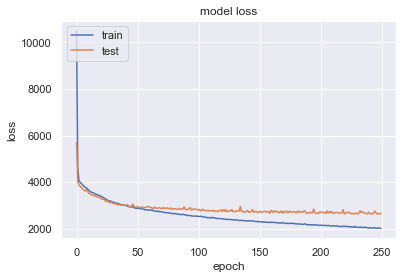

In [30]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()